In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
import pathlib
import matplotlib.pyplot as plt
from matplotlib.legend import Legend
from operator import attrgetter
from compounding import saving_summary, compound
from more_itertools import sliding_window, take
from itertools import chain
from operator import attrgetter
from statistics import mean

In [2]:
def read_jsonfile(path: pathlib.Path):
    with open(path, "r") as file:
        obj = json.load(file)
    return obj

In [3]:
path = pathlib.Path(f'../data/monthly-returns.json')
returns = read_jsonfile(path)

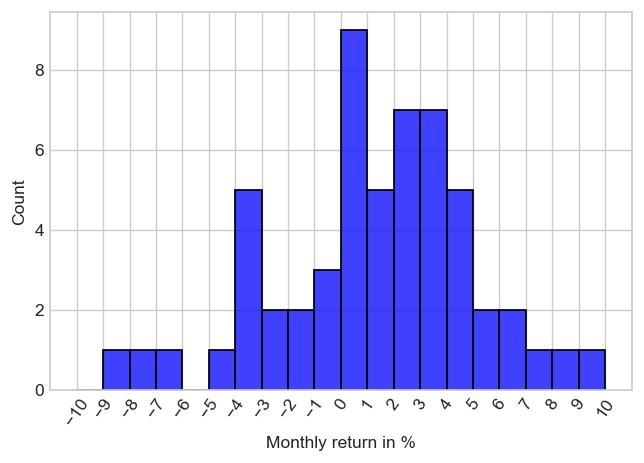

In [4]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(dpi = 125)
sns.histplot(x=np.array(returns['values']) * 100, color="blue", bins=np.arange(-10, 10.01, 1), ax=ax)
plt.xticks(np.arange(-10, 10.01, 1), rotation=55);
plt.xlabel('Monthly return in %');

In [5]:
periods = 120
saving_rate = 5_000
path = pathlib.Path(f'../data/realized-paths-{periods}.json')
realized_paths = read_jsonfile(path)

In [6]:
sampled_returns = list(map(compound, realized_paths.values()))
mean_returns = np.mean(sampled_returns)
percentiles = [np.quantile(sampled_returns, q) for q in np.arange(0, 1.001, 0.01)]

In [7]:
def moving_average(arr: list[float], size: int) -> list[float]:
    windows = sliding_window(iterable=arr, n=size)
    ma = chain(take(size-1, arr), map(mean, windows))
    return list(ma)

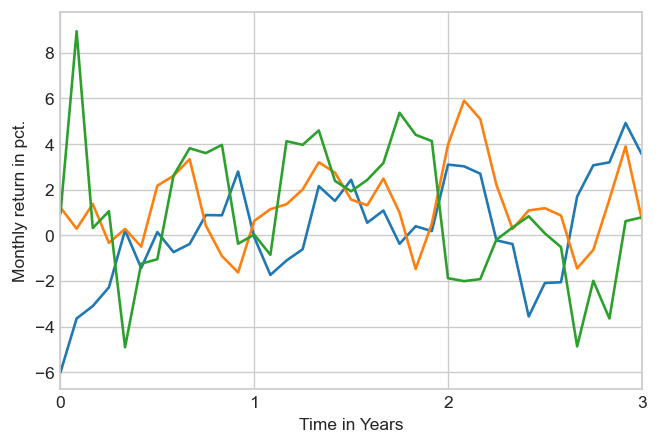

In [8]:
ma_size = 3
n_paths = 3
n_years = 3

fig, ax = plt.subplots(dpi=125)
for i in range(n_paths):
    path = realized_paths[str(i)]
    ma = moving_average(path, ma_size)
    ma = pd.Series(ma, index=np.arange(len(ma)) / 12).multiply(100)
    ax.plot(ma)
ax.set_xlim(0,n_years);
ax.set_xticks(np.arange(n_years+1));
ax.set_xlabel('Time in Years')
ax.set_ylabel('Monthly return in pct.');

In [9]:
def has_profit(path: list[float], saving_rate: float):
    saving = saving_summary(path, saving=saving_rate)
    saving = list(map(attrgetter('total'), saving))
    periods = len(path)
    passive = np.arange(periods+1) * saving_rate
    return passive > np.array(saving)

In [10]:
eval_matrix = np.array([has_profit(path, 5_000) for i, path in realized_paths.items()])
prob_loss = eval_matrix.mean(axis=0) * 100

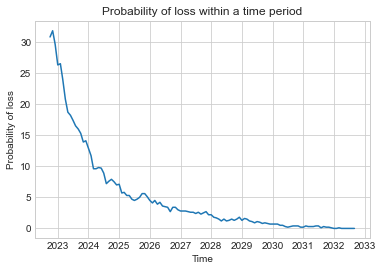

In [11]:
from datetime import datetime
date_range = pd.date_range(start=datetime.today(), freq='M', periods=len(prob_loss))
prob_loss_series = pd.Series(prob_loss, index=date_range)
sns.lineplot(data=prob_loss_series[1:]);
plt.title('Probability of loss within a time period');
plt.xlabel('Time');
plt.ylabel('Probability of loss');

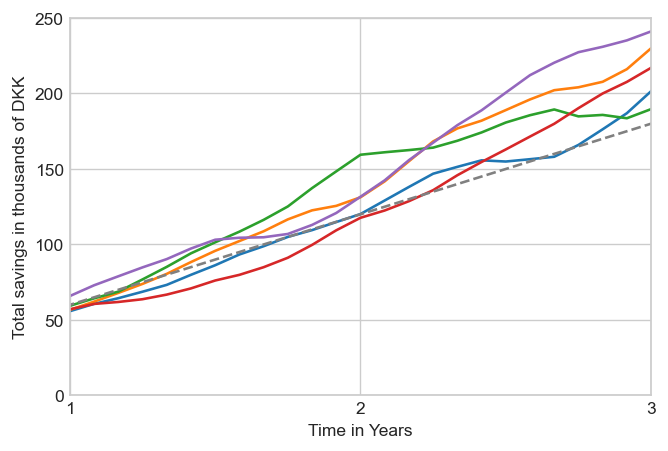

In [13]:
ma_size = 3
n_paths = 5
n_years = 3
passive = np.arange(periods+1) * saving_rate
years = np.arange(periods+1) / 12
eps = 0.001

fig, ax = plt.subplots(dpi=125)
for i in range(n_paths):
    path = realized_paths[str(i)]
    saving = saving_summary(path, saving=saving_rate)
    saving = list(map(attrgetter('total'), saving))
    ma = moving_average(saving, ma_size)
    ma = pd.Series(ma, index=years).divide(1_000)
    ax.plot(ma)
ax.set_ylim(0, 250);
ax.set_xlim(1,n_years);
ax.plot(pd.Series(passive, index=years).divide(1_000), linestyle = "--", color = "grey")
ax.set_xlabel('Time in Years')
ax.set_ylabel('Total savings in thousands of DKK');
ax.set_xticks(np.arange(1, n_years+1));

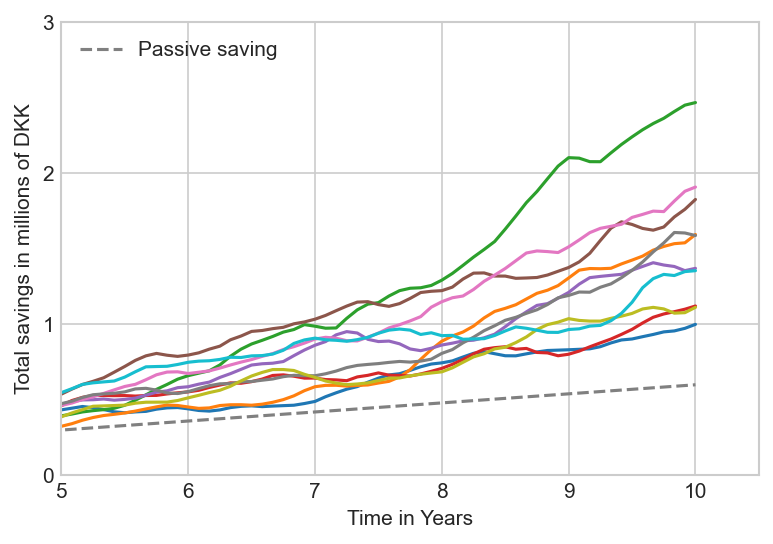

In [14]:
ma_size = 3
n_paths = 10
passive = np.arange(periods+1) * saving_rate
years = np.arange(periods+1) / 12
lines = []

fig, ax = plt.subplots(dpi=150)
for i in range(n_paths):
    path = realized_paths[str(i)]
    saving = saving_summary(path, saving=saving_rate)
    saving = list(map(attrgetter('total'), saving))
    ma = moving_average(saving, ma_size)
    ma = pd.Series(ma, index=years)
    ax.plot(ma / 1_000_000)
ax.set_ylim(0);
ax.set_xlim(5);
lines += ax.plot(pd.Series(passive, index=years) / 1_000_000, linestyle = "--", color = "grey")
ax.set_xlabel('Time in Years')
ax.set_ylabel('Total savings in millions of DKK');
ax.set_yticks(np.arange(0,3+eps, 1));
leg = Legend(ax, lines, ['Passive saving'],
             loc='upper left', frameon=False)
ax.add_artist(leg);

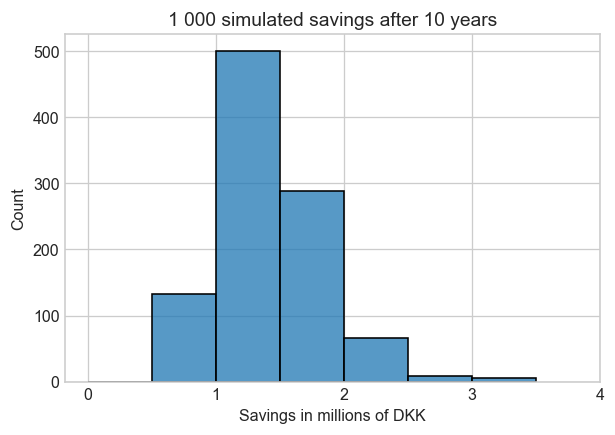

In [15]:
fig, ax = plt.subplots(dpi = 115)
sns.histplot(np.array(sampled_returns) / 1_000_000, bins=np.arange(0,3.5+eps, 0.5));
ax.set_title('1 000 simulated savings after 10 years');
ax.set_xlabel('Savings in millions of DKK');
ax.set_xticks(np.arange(0,4+eps, 1));

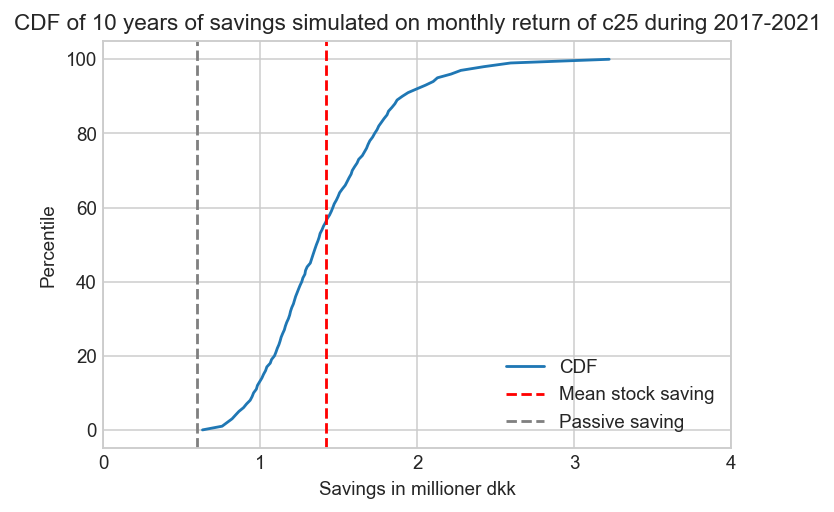

In [16]:
lines = []

fig, ax = plt.subplots(dpi = 135)
lines += ax.plot(np.array(percentiles) / 1_000_000, range(len(percentiles)))
lines += [
    ax.axvline(np.array(mean_returns) / 1_000_000, linestyle = "--", color = "red"),
    ax.axvline(periods * saving_rate / 1_000_000, linestyle = "--", color = "grey"),
]
ax.set(ylabel = "Percentile")
ax.set(xlabel = f"Savings in millioner dkk")
ax.set(title  = f"CDF of {periods // 12} years of savings simulated on monthly return of c25 during 2017-2021")
ax.set_xlim(0)
ax.set_xticks(np.arange(0,4+eps, 1));
leg = Legend(ax, lines, ['CDF', 'Mean stock saving', 'Passive saving'],
             loc='lower right', frameon=False)
ax.add_artist(leg);